In [1]:
# --- 1. Download Data ---
print("Downloading 1GB 'val2017.zip' (images)...")
!wget -q http://images.cocodataset.org/zips/val2017.zip

print("Downloading 'annotations_trainval2017.zip' (masks)...")
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# --- 2. Unzip ONLY the small annotation file ---
print("Unzipping annotations (this is fast)...")
!unzip -q annotations_trainval2017.zip -d .

# --- 3. Install Tools ---
print("Installing pycocotools and tqdm...")
!pip install -q pycocotools tqdm

print("--- Setup Complete! ---")

Unzipping annotations (this is fast)...
Installing pycocotools and tqdm...
--- Setup Complete! ---


In [2]:
# --- Import all necessary libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile  # <-- Important: for reading from the zip
import cv2      # <-- Important: for decoding images from memory
from PIL import Image
from tqdm.notebook import tqdm # For a nice progress bar

print("--- Libraries Imported ---")

# --- Set up device (it should find the T4 GPU) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Set up paths ---
IMAGE_ZIP_FILE = 'val2017.zip'
ANN_FILE = 'annotations/instances_val2017.json'

# --- Step 1: Create the PyTorch Dataset ---
class CocoMainSubjectDataset(Dataset):
    """
    This Dataset class reads images directly from a ZIP file
    and finds the 'main subject' (largest) mask.
    """
    def __init__(self, zip_path, ann_file, imgIds, transform, mask_transform):
        self.zip_file = zipfile.ZipFile(zip_path, 'r')
        self.coco = COCO(ann_file)
        self.imgIds = imgIds
        self.transform = transform
        self.mask_transform = mask_transform

        # We must open the zip file handle for each worker
        self.zip_handle = None

    def __len__(self):
        return len(self.imgIds)

    def __getitem__(self, idx):
        if self.zip_handle is None:
             self.zip_handle = zipfile.ZipFile(self.zip_file.filename, 'r')

        # --- Load Image (from ZIP) ---
        imgId = self.imgIds[idx]
        img_info = self.coco.loadImgs(imgId)[0]
        img_path_in_zip = 'val2017/' + img_info['file_name'] # Path inside the zip

        try:
            # Read image data from zip file into memory
            img_data = self.zip_handle.read(img_path_in_zip)
            # Decode image data from memory
            img_array = np.frombuffer(img_data, dtype=np.uint8)
            image_bgr = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
            image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
            image_pil = Image.fromarray(image_rgb)
        except Exception as e:
            # If an image is bad, skip it and get the next one
            print(f"Warning: Failed to load {img_path_in_zip}. Error: {e}. Skipping.")
            return self.__getitem__((idx + 1) % len(self))

        # --- Load and Create "Main Subject" Mask ---
        annIds = self.coco.getAnnIds(imgIds=img_info['id'])
        anns = self.coco.loadAnns(annIds)

        main_subject_mask_np = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

        if anns:
            largest_ann = max(anns, key=lambda x: x['area'])
            main_subject_mask_np = self.coco.annToMask(largest_ann)

        mask_pil = Image.fromarray(main_subject_mask_np, mode='L')

        # --- Apply Transformations (Image and Mask) ---
        state = torch.get_rng_state()
        image = self.transform(image_pil)

        torch.set_rng_state(state)
        mask = self.mask_transform(mask_pil)

        mask = (mask > 0.5).float()

        return image, mask

print("--- Step 1 Complete: Dataset class defined ---")

--- Libraries Imported ---
Using device: cpu
--- Step 1 Complete: Dataset class defined ---


In [3]:
# --- Step 2: Define Transforms and Create DataLoaders ---

# Define the transformation pipeline for the IMAGE
image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the transformation pipeline for the MASK
mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

print("Loading annotation file...")
coco = COCO(ANN_FILE)
all_img_ids = coco.getImgIds()
np.random.shuffle(all_img_ids)
print(f"Loaded {len(all_img_ids)} total image IDs from val2017.")

# --- Use a 200-image subset for a SUPER-FAST debug run ---
subset_ids = all_img_ids[:200]
train_ids = subset_ids[:160]  # 160 images for training
val_ids = subset_ids[160:] # 40 images for validation

print(f"Using a {len(subset_ids)}-image subset for this fast run.")
print(f"Training images: {len(train_ids)}")
print(f"Validation images: {len(val_ids)}")

# Create the two datasets
train_dataset = CocoMainSubjectDataset(
    zip_path=IMAGE_ZIP_FILE,
    ann_file=ANN_FILE,
    imgIds=train_ids,
    transform=image_transform,
    mask_transform=mask_transform
)
val_dataset = CocoMainSubjectDataset(
    zip_path=IMAGE_ZIP_FILE,
    ann_file=ANN_FILE,
    imgIds=val_ids,
    transform=image_transform,
    mask_transform=mask_transform
)

# Create DataLoaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("--- Step 2 Complete: DataLoaders are ready ---")

Loading annotation file...
loading annotations into memory...
Done (t=3.01s)
creating index...
index created!
Loaded 5000 total image IDs from val2017.
Using a 200-image subset for this fast run.
Training images: 160
Validation images: 40
loading annotations into memory...
Done (t=1.37s)
creating index...
index created!
loading annotations into memory...
Done (t=3.71s)
creating index...
index created!
--- Step 2 Complete: DataLoaders are ready ---


In [4]:
# --- Step 3: Load the Model ---
print("Loading pre-trained FCN-ResNet50 model (requires internet)...")

model = models.segmentation.fcn_resnet50(weights=models.segmentation.FCN_ResNet50_Weights.DEFAULT)

# --- Modify the final layer ---
model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
model.to(device) # Move model to the GPU

print("--- Step 3 Complete: Model loaded and modified ---")

Loading pre-trained FCN-ResNet50 model (requires internet)...
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


100%|██████████| 135M/135M [00:01<00:00, 80.1MB/s]


--- Step 3 Complete: Model loaded and modified ---


In [5]:
# --- Step 4: Define Loss and Optimizer ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4) # 0.0001 learning rate
print("--- Step 4 Complete: Loss and optimizer are set ---")

--- Step 4 Complete: Loss and optimizer are set ---


Starting fast training for 2 epochs...


Epoch 1/2 [Train]:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipython-input-2455755019.py:77: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(main_subject_mask_np, mode='L')
/tmp/ipython-input-2455755019.py:77: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(main_subject_mask_np, mode='L')


Epoch 1/2 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipython-input-2455755019.py:77: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(main_subject_mask_np, mode='L')
/tmp/ipython-input-2455755019.py:77: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(main_subject_mask_np, mode='L')


Epoch 1/2 | Train Loss: 0.5352 | Val Loss: 0.8127


Epoch 2/2 [Train]:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipython-input-2455755019.py:77: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(main_subject_mask_np, mode='L')
/tmp/ipython-input-2455755019.py:77: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(main_subject_mask_np, mode='L')


Epoch 2/2 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipython-input-2455755019.py:77: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(main_subject_mask_np, mode='L')
/tmp/ipython-input-2455755019.py:77: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(main_subject_mask_np, mode='L')


Epoch 2/2 | Train Loss: 0.3546 | Val Loss: 0.4186
--- Training Finished ---


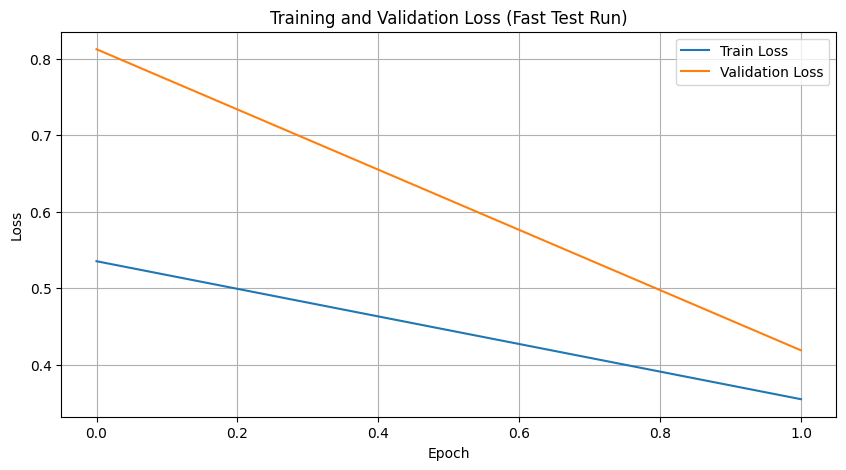

--- Step 5 Complete: Training and plotting finished. ---


In [6]:
# --- Step 5: Start Training (SUPER FAST) ---
NUM_EPOCHS = 2  # Only 2 epochs for a fast test
train_losses = []
val_losses = []

print(f"Starting fast training for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):

    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)

    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            running_val_loss += loss.item() * images.size(0)

    epoch_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

print("--- Training Finished ---")

# --- 6. Plot the Loss Curve ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss (Fast Test Run)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("--- Step 5 Complete: Training and plotting finished. ---")